Import the libraries

In [27]:
import cv2
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.distributions import Categorical
import gymnasium as gym
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import torch.nn.functional as F
import ale_py

Build the AI

In [28]:
class Network(nn.Module):
    def __init__(self,action_Size):
        super(Network,self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=4,out_channels=32,kernel_size=(3,3),stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(in_features=512,out_features=128)
        self.fc2a = torch.nn.Linear(in_features=128,out_features=action_Size)
        self.fc2s = torch.nn.Linear(in_features=128,out_features=1)
    def forward(self,state):
        x = self.conv1(state)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        action = self.fc2a(x)
        state = self.fc2s(x)[0]
        return action,state

In [29]:
#Build the env
class PreprocessAtari(ObservationWrapper):

  def __init__(self, env, height = 42, width = 42, crop = lambda img: img, dim_order = 'pytorch', color = False, n_frames = 4):
    super(PreprocessAtari, self).__init__(env)
    self.img_size = (height, width)
    self.crop = crop
    self.dim_order = dim_order
    self.color = color
    self.frame_stack = n_frames
    n_channels = 3 * n_frames if color else n_frames
    obs_shape = {'tensorflow': (height, width, n_channels), 'pytorch': (n_channels, height, width)}[dim_order]
    self.observation_space = Box(0.0, 1.0, obs_shape)
    self.frames = np.zeros(obs_shape, dtype = np.float32)

  def reset(self):
    self.frames = np.zeros_like(self.frames)
    obs, info = self.env.reset()
    self.update_buffer(obs)
    return self.frames, info

  def observation(self, img):
    img = self.crop(img)
    img = cv2.resize(img, self.img_size)
    if not self.color:
      if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('float32') / 255.
    if self.color:
      self.frames = np.roll(self.frames, shift = -3, axis = 0)
    else:
      self.frames = np.roll(self.frames, shift = -1, axis = 0)
    if self.color:
      self.frames[-3:] = img
    else:
      self.frames[-1] = img
    return self.frames

  def update_buffer(self, obs):
    self.frames = self.observation(obs)
def make_env():
  env = gym.make("KungFuMasterDeterministic-v4", render_mode = 'rgb_array')
  env = PreprocessAtari(env, height = 42, width = 42, crop = lambda img: img, dim_order = 'pytorch', color = False, n_frames = 4)
  return env

env = make_env()

state_shape = env.observation_space.shape
number_actions = env.action_space.n
print("State shape:", state_shape)
print("Number actions:", number_actions)

State shape: (4, 42, 42)
Number actions: 14


Hyperparameters

In [30]:
learning_rate = 1e-4
discount_factor = 0.99
number_environments = 10


A3C class

In [31]:
class Agent():
    def __init__(self,action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.action_size = action_size
        self.network = Network(action_size).to(self.device)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate)
    def act(self,state):
        if state.ndim == 3:
            state = [state]
        state = torch.tensor(state,dtype = torch.float32,device= self.device)
        action,_ = self.network.forward(state)
        policy = F.softmax(action,dim = -1)
        return np.array([np.random.choice(len(p), p=p) for p in policy.detach().cpu().numpy()])
    def step(self,state,action,reward,next_state,done):
        state = torch.tensor(state,dtype = torch.float32,device = self.device)
        batch_size = state.shape[0]
        state = torch.tensor(state,dtype = torch.float32,device = self.device)
        next_state = torch.tensor(next_state,dtype = torch.float32,device = self.device)
        reward = torch.tensor(reward,dtype = torch.float32,device = self.device)
        done = torch.tensor(done,dtype = torch.bool,device = self.device).to(dtype = torch.float32)
        action_values,state_value = self.network(state)
        _,next_state_value = self.network(next_state)
        target_state_value = reward + discount_factor*next_state_value*(1.0-done)
        advantage = target_state_value-state_value
        probs = F.softmax(action_values,dim = -1)
        logprobs = F.log_softmax(action_values,dim = -1)
        entropy = -torch.sum(probs*logprobs,axis = -1)
        batch_idx = np.arange(batch_size)
        logp_actions = logprobs[batch_idx,action]
        actor_loss = -(logp_actions*advantage.detach()).mean() - 0.001*entropy.mean()
        critic_loss = F.mse_loss(target_state_value.detach(),state_value)
        total_loss = actor_loss + critic_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

In [32]:
agent = Agent(number_actions) #Initial the agent

Evaluate the agent

In [33]:
def evaluate(agent,env,n_episodes = 1):
    episodes_rewards = []
    for _ in range(n_episodes):
        state,_ = env.reset()
        total_reward = 0
        while True:
            action = agent.act(state)
            state, reward, done, info, _ = env.step(action[0])
            total_reward += reward
            if done:
                break
        episodes_rewards.append(total_reward)
    return episodes_rewards

Manage multiple envs

In [34]:
class EnvBatch:
    def __init__(self,n_envs = 10):
        self.envs = [make_env() for _ in range(n_envs)]
    def reset(self):
        _state = []
        for env in self.envs:
            _state.append(env.reset()[0])
        return np.array(_state)
    def step(self,actions):
        next_state, reward, done, info,_ = map(np.array, zip(*[env.step(a) for env,a in zip(self.envs,actions)]))
        for i in range(len(self.envs)):
            if done[i]:
                next_state[i] = self.envs[i].reset()[0]
        return next_state, reward, done, info



Training

In [35]:
import tqdm

env_batch = EnvBatch(number_environments)
batch_states = env_batch.reset()


with tqdm.trange(0,3001) as pbar:
    for i in pbar:
        batch_actions = agent.act(batch_states)
        batch_next_states, batch_reward, done,_ = env_batch.step(batch_actions)
        batch_reward *= 0.01
        agent.step(batch_states, batch_actions, batch_reward, batch_next_states,done)
        batch_states = batch_next_states
        if i%1000 == 0:
            print("Average ageent reward: ", np.mean(evaluate(agent, env, n_episodes = 10)))

  0%|          | 0/3001 [00:00<?, ?it/s]/tmp/ipykernel_12905/2041159538.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state,dtype = torch.float32,device = self.device)
/tmp/ipykernel_12905/2041159538.py:31: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(target_state_value.detach(),state_value)
/tmp/ipykernel_12905/2041159538.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor(state,dtype = t

Average ageent reward:  690.0


 34%|███▎      | 1006/3001 [01:44<1:08:15,  2.05s/it]

Average ageent reward:  580.0


 67%|██████▋   | 2006/3001 [02:55<38:03,  2.30s/it]  

Average ageent reward:  800.0


100%|██████████| 3001/3001 [04:14<00:00, 11.80it/s]

Average ageent reward:  750.0


Visualize

GIF saved successfully.



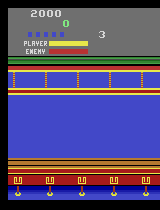

In [43]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
import gymnasium as gym

def show_video_of_model(agent, env):
    state, _ = env.reset()
    done = False
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action[0])

    env.close()
    # Save the frames as a GIF instead of MP4
    imageio.mimsave('video.gif', frames, format='GIF', fps=30)
    print("GIF saved successfully.")

def show_video():
    giflist = glob.glob('*.gif')  # Change to look for GIFs
    if len(giflist) > 0:
        gif = giflist[0]
        video = io.open(gif, 'rb').read()  # Open the GIF file
        encoded = base64.b64encode(video)  # Encode the GIF in base64
        display(HTML(data=f'''<img src="data:image/gif;base64,{encoded.decode('ascii')}" style="height: 400px;" autoplay loop>'''))
    else:
        print("Could not find GIF")

# Run the functions
show_video_of_model(agent, env)
show_video()
